# Summary

## bybit vs bitget的spread出現長期的spread和反向收斂，所以初步用分k研究

In [379]:
bybit_df = pd.read_csv('/Users/johnsonhsiao/DC_capital/data/bybit/5m_BTC.csv')
bitget = pd.read_csv('/Users/johnsonhsiao/DC_capital/data/bitget/5m_BTC.csv')
bitget_df = bitget.drop(bitget.index[-3:])
# print(bybit)
# print(bitget)

## 用 2023/1/1 ~ 2023/7/4 可以看出來其實不會穩定有正價差或逆價差，這樣可以用正價差的時候和逆價差來轉spread收斂。

                      time    bybit   bitget    spread
0      2022-12-31 16:00:00  16599.5  16591.0  0.051206
1      2022-12-31 16:05:00  16600.0  16591.0  0.054217
2      2022-12-31 16:10:00  16600.0  16590.5  0.057229
3      2022-12-31 16:15:00  16597.5  16588.0  0.057238
4      2022-12-31 16:20:00  16609.0  16597.0  0.072250
...                    ...      ...      ...       ...
53191  2023-07-04 08:35:00  30959.7  30968.0 -0.026809
53192  2023-07-04 08:40:00  30941.6  30952.5 -0.035228
53193  2023-07-04 08:45:00  30908.1  30918.0 -0.032030
53194  2023-07-04 08:50:00  30915.6  30926.5 -0.035257
53195  2023-07-04 08:55:00  30906.2  30926.5 -0.065683

[53196 rows x 4 columns]


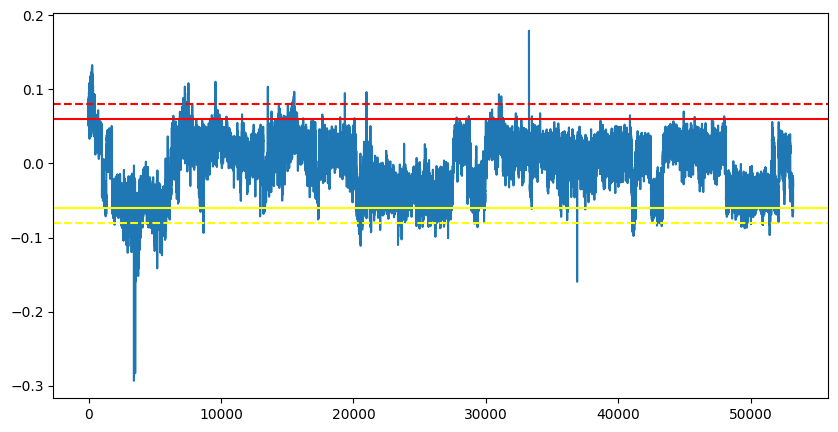

In [392]:
import matplotlib.pyplot as plt

bitget_make = -0.0015
bitget_take = -0.035
bybit_make = 0.0025
bybit_take = -0.03

bitget_df['close'] = bitget_df['close'].astype(float)

data = pd.DataFrame()
data['time'] = bitget_df['time']
data['bybit'] = bybit_df['close']
data['bitget'] = bitget_df['close']
data['spread'] = (data['bybit'] - data['bitget']) / (data['bybit']) * 100

data.to_csv('/Users/johnsonhsiao/DC_capital/data/spread.csv')
print(data)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(data.index, data['spread'], label='spread')

ax.axhline(y=0.08, color='red', linestyle='--', label='cost')
ax.axhline(y=-0.08, color='yellow', linestyle='--', label='cost')
ax.axhline(y=0.06, color='red', linestyle='-', label='cost')
ax.axhline(y=-0.06, color='yellow', linestyle='-', label='cost')
plt.show()


In [253]:
median = (data['spread'].median())
print(median)
print(max(data['spread']))
print(min(data['spread']))

#可以代表說這一個月來的平均spread在-0.0035 (bybit - bitget)

0.000984037275329603
0.22977324838293778
-0.19786359051289582


## 進場的時候去判斷現在的spread(bybit - bitget)跟過去一段時間的價差中位數，之後是用動態的，如MA的spread來判斷當時行情是否能夠回歸到某個數字，如果大於成本就進場，意思是在價差出現時，就用偵測到的價格在bybit_take掛單，成交後馬上用偵測到的spread去掛bitget_make，然後因為出場的時候會是在市場較頻穩的時候，可以利用我們的優勢都用make出場就可以 （詳細的掛單方式可以再研究一下）

## 以下用[60 , 720, 1440, 7200, 14400, 21600]為分鐘單位來看他的median，只要觀察到的spread > median 和 cost的總和我們就可以進場，以下的dataframe是在不同的cost下每一個時期的交易次數和年化報酬率

In [331]:
# cost = abs(bitget_make + bybit_take + bitget_make + bybit_make) + 0.005
import numpy as np
pd.set_option('mode.chained_assignment', None)


result = {}
period = [60 ,120, 240, 360, 480, 600, 720, 960, 1440, 1920, 
          2160, 2880, 3600, 4800, 6000, 7200, 14400, 21600]
# period = [4800, 6000, 7200, 14400, 21600]
table_dict = {}

for p in period:

    for cost in [0.035,0.04,0.045,0.05,0.055,0.065,0.07,0.075,0.08,0.085,0.09,0.095,0.1,0.105,0.11,0.115,0.12,0.125,0.13]:

        count = 0
        month_return = 0
        
        for i in range(int(len(data)/p)-1):

            pre_data = data.loc[i*p:(i+1)*p] 
            median = pre_data['spread'].median()
            observe = data.loc[(i+1)*p:(i+2)*p] #從第二期開始

            observe['enter'] = abs(observe['spread'] - median) >  cost
            observe['pnl'] = abs(observe['spread'] - median) - cost

            count += observe['enter'].sum()
            chance = observe[observe['enter'] == True]
            chance.reset_index(inplace=True)
            month_return += chance['pnl'].sum()

        
        APR = month_return/30 * 365
        result[cost] = [count, APR]

    info = pd.DataFrame(result).T
    info.index.name = 'cost'
    info = info.rename(columns={0: 'count'})
    info = info.rename(columns={1: 'APR'})
    table_dict[f'{p} to median'] = info

table_keys = list(table_dict.keys())
table_info = list(table_dict.values())
table = pd.concat(table_info, axis=1, keys=table_keys)


# 這個table是扣掉cost和median後的累積apr，但是不嚴謹的地方是實際出場時機不會是這樣，粗估而已，可以發現period越長交易機會越多，但持倉的部分和時機要再觀察。

In [337]:
pd.set_option('display.max_columns', None)  # 显示所有列
table.to_html('arbitrage_table.html')
display(table)

60 to median             120 to median             240 to median  \
             count         APR         count         APR         count   
cost                                                                     
0.035        821.0  158.155034        1235.0  271.749382        1569.0   
0.040        541.0  117.886436         877.0  208.551964        1094.0   
0.045        368.0   90.776206         683.0  161.926069         780.0   
0.050        261.0   71.698407         571.0  124.031158         607.0   
0.055        210.0   57.375774         471.0   92.182068         447.0   
0.065        154.0   35.194285         266.0   47.238495         260.0   
0.070        121.0   26.812843         185.0   33.941638         182.0   
0.075         85.0   20.690002         116.0   24.615397         121.0   
0.080         56.0   16.486458          73.0   18.906060          70.0   
0.085         41.0   13.510758          54.0   15.217965          42.0   
0.090         32.0   11.384810          36.0   12.669735          25.0   
0.095         26.0    9.674956          25.0   10.868867          17.0   
0.100         19.0    8.330384          22.0    9.513167          13.0   
0.105         16.0    7.302104          19.0    8.245465          11.0   
0.110         11.0    6.487507          14.0    7.214777           9.0   
0.115          9.0    5.889595          12.0    6.416606           9.0   
0.120          9.0    5.342095           8.0    5.774033           7.0   
0.125          8.0    4.807880           8.0    5.287367           7.0   
0.130          7.0    4.326364           8.0    4.800700           7.0   

                  360 to median             480 to median              \
              APR         count         APR         count         APR   
cost                                                                    
0.035  294.219091        2145.0  494.918968        2509.0  648.102137   
0.040  214.881895        1676.0  380.180491        2059.0  510.311071   
0.045  158.443300        1401.0  286.430517        1754.0  394.629410   
0.050  116.237261        1175.0  208.136462        1491.0  295.739355   
0.055   84.544761         919.0  144.699042        1222.0  212.935154   
0.065   42.589739         471.0   61.018099         674.0   97.070171   
0.070   29.391477         298.0   38.218527         480.0   62.223558   
0.075   19.954762         165.0   24.168705         301.0   39.003202   
0.080   14.421978          93.0   16.595830         179.0   24.929146   
0.085   11.001187          48.0   12.577786          99.0   16.681253   
0.090    8.886486          31.0   10.244447          52.0   12.094060   
0.095    7.612611          24.0    8.588757          29.0    9.717255   
0.100    6.678829          15.0    7.453509          20.0    8.240325   
0.105    5.996747          13.0    6.622028          15.0    7.233811   
0.110    5.428175           9.0    6.006840          12.0    6.434076   
0.115    4.880675           9.0    5.459340           8.0    5.826039   
0.120    4.405102           8.0    4.961463           8.0    5.339372   
0.125    3.979269           8.0    4.474796           8.0    4.852705   
0.130    3.553435           7.0    4.048794           8.0    4.366039   

      600 to median             720 to median              960 to median  \
              count         APR         count          APR         count   
cost                                                                       
0.035        3306.0  804.889188        3829.0  1003.979930        4511.0   
0.040        2744.0  621.947339        3133.0   793.180065        3749.0   
0.045        2294.0  469.429489        2653.0   617.527397        3097.0   
0.050        1930.0  341.316882        2263.0   468.150275        2452.0   
0.055        1538.0  236.305138        1903.0   341.459418        1919.0   
0.065         754.0   96.921372        1166.0   154.837212        1043.0   
0.070         469.0   60.416951         794.0    95.253642         705.0   
0.075     

In [330]:
for cost in [0.035,0.04,0.045,0.05,0.055,0.065,0.07,0.075,0.08,0.085,0.09,0.095,0.1]:
#     cost = abs(bitget_make + bybit_take + bitget_make + bybit_make) + 0.005
    median = (data['spread'].median())
    data['enter'] = abs(data['spread'] - median) >  cost
    data['pnl'] = abs(data['spread'] - median) - cost
    count = data['enter'].sum()
    chance = data[data['enter'] == True]
    chance.reset_index(inplace=True)
    month_return = chance['pnl'].sum()
    APR = month_return/30 * 365
#     print(f'cost is {cost}')
#     print(f'APR is {APR}')
#     print(f'trade_num is {count}') #總共的交易機會
#     print(f"freq is {count / len(data)}")
#     print('-------------------------------')
    result[cost] = [count, APR]

info = pd.DataFrame(result).T
info.index.name = 'cost'
info = info.rename(columns={0: 'count'})
info = info.rename(columns={1: 'APR'})
info

,count,APR
cost,,
0.035,13563.0,1908.702899
0.040,9200.0,1223.830505
0.045,6028.0,766.954924
0.050,3923.0,468.768865
0.055,2460.0,277.403535
0.065,857.0,86.971059
0.070,441.0,48.345985
0.075,244.0,27.886051
0.080,131.0,16.766114


0.01177354211761484
0.01438537047536631


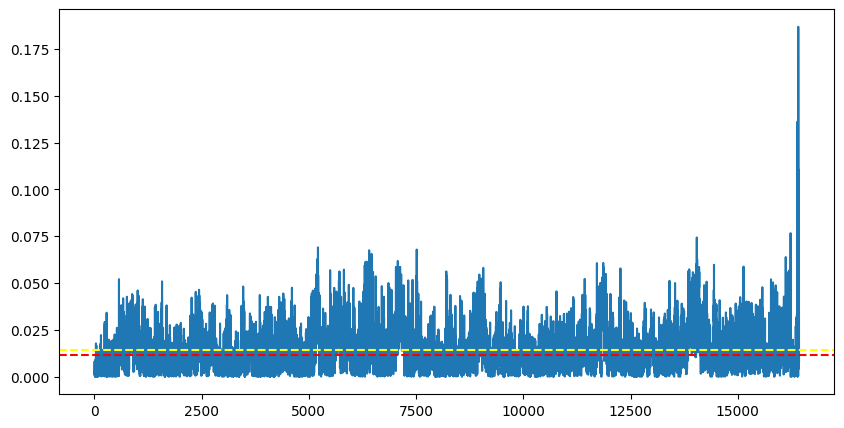

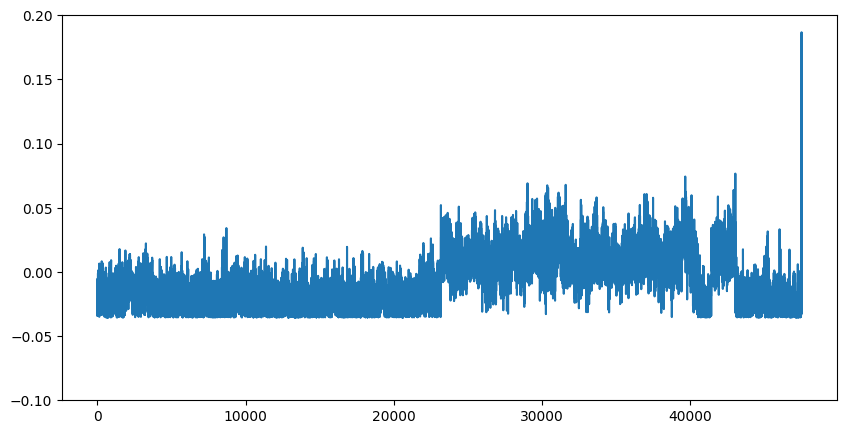

In [243]:
trade = data[data['enter'] == True]
trade.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(trade.index, trade['pnl'], label='pnl')
ax.axhline(y=trade['pnl'].median(), color='red', linestyle='--', label='median')
ax.axhline(y=trade['pnl'].mean(), color='yellow', linestyle='--', label='mean')

print(trade['pnl'].median())
print(trade['pnl'].mean())
plt.show()


fig, ax = plt.subplots(figsize=(10, 5))

ax.set_ylim(-0.1, 0.2)
ax.plot(data.index, data['pnl'], label='pnl')


plt.show()

0.027348961663413576
0.06527463017154492
-0.022386806708579742
220
        bybit   bitget    spread  enter       pnl
0     26906.1  26903.0  0.011522  False -0.031500
1     26906.2  26901.0  0.019328  False -0.023694
2     26912.2  26906.5  0.021182  False -0.021840
3     26906.7  26905.0  0.006318  False -0.034296
4     26898.6  26889.5  0.033836  False -0.009185
...       ...      ...       ...    ...       ...
5036  27058.9  27052.0  0.025503  False -0.017519
5037  27057.7  27051.0  0.024765  False -0.018257
5038  27053.0  27050.0  0.011090  False -0.031932
5039  27052.0  27047.0  0.018485  False -0.024537
5040  27052.0  27045.5  0.024031  False -0.018991

[5041 rows x 5 columns]


/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['enter'] = abs(observe['spread'] - median_all) >  cost
/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['pnl'] = abs(observe['spread'] - median_all) - cost


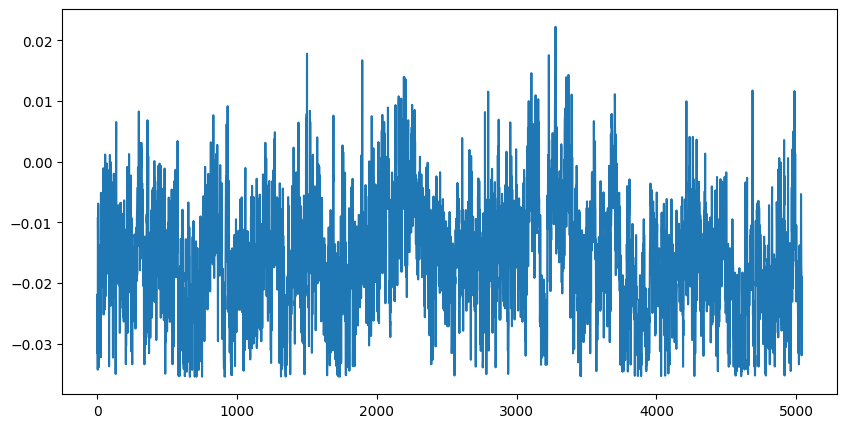

0.022797805527367397
0.07720195881048983
-0.03796742549861021
101
         bybit   bitget    spread  enter       pnl
5040   27052.0  27045.5  0.024031  False -0.018991
5041   27049.6  27042.5  0.026252  False -0.016770
5042   27049.6  27043.0  0.024403  False -0.018619
5043   27049.5  27043.0  0.024033  False -0.018989
5044   27049.5  27043.0  0.024033  False -0.018989
...        ...      ...       ...    ...       ...
10076  26280.0  26277.0  0.011416  False -0.031606
10077  26292.3  26291.0  0.004945  False -0.032923
10078  26313.9  26306.5  0.028126  False -0.014896
10079  26337.1  26325.5  0.044054   True  0.001032
10080  26301.4  26300.0  0.005323  False -0.033301

[5041 rows x 5 columns]


/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['enter'] = abs(observe['spread'] - median_all) >  cost
/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['pnl'] = abs(observe['spread'] - median_all) - cost


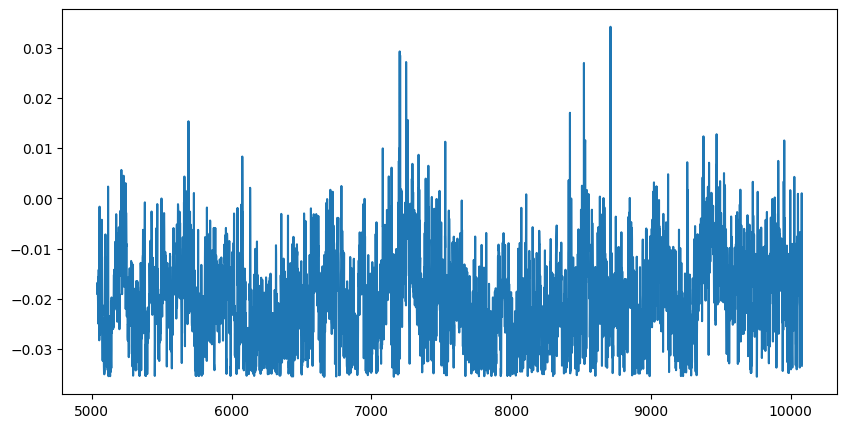

0.019683847132217644
0.06281620960936092
-0.03862954848301551
79
         bybit   bitget    spread  enter       pnl
10080  26301.4  26300.0  0.005323  False -0.033301
10081  26303.3  26297.0  0.023954  False -0.019068
10082  26352.6  26346.0  0.025048  False -0.017974
10083  26359.6  26359.5  0.000379  False -0.028357
10084  26379.8  26374.0  0.021989  False -0.021033
...        ...      ...       ...    ...       ...
15116  25705.8  25707.5 -0.006613  False -0.021365
15117  25705.7  25708.0 -0.008947  False -0.019031
15118  25713.6  25714.5 -0.003500  False -0.024478
15119  25713.8  25716.5 -0.010500  False -0.017478
15120  25713.8  25711.5  0.008945  False -0.034077

[5041 rows x 5 columns]


/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['enter'] = abs(observe['spread'] - median_all) >  cost
/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['pnl'] = abs(observe['spread'] - median_all) - cost


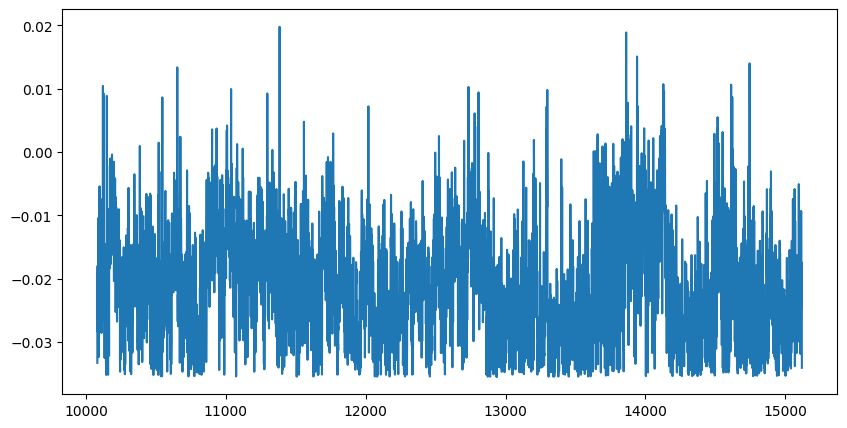

0.020042320129815373
0.06258305776184724
-0.04258429100032243
54
         bybit   bitget    spread  enter       pnl
15120  25713.8  25711.5  0.008945  False -0.034077
15121  25699.2  25699.5 -0.001167  False -0.026811
15122  25695.5  25698.5 -0.011675  False -0.016304
15123  25697.4  25700.0 -0.010117  False -0.017861
15124  25699.8  25701.5 -0.006615  False -0.021363
...        ...      ...       ...    ...       ...
20156  25951.3  25944.0  0.028134  False -0.014888
20157  25961.5  25956.5  0.019261  False -0.023761
20158  25963.9  25960.0  0.015022  False -0.028000
20159  25975.4  25968.5  0.026567  False -0.016455
20160  25968.0  25966.5  0.005777  False -0.033755

[5041 rows x 5 columns]


/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['enter'] = abs(observe['spread'] - median_all) >  cost
/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['pnl'] = abs(observe['spread'] - median_all) - cost


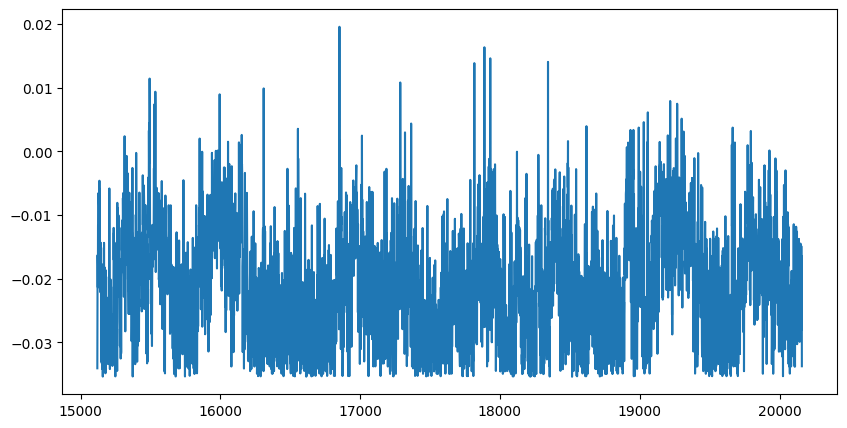

0.009172793494492425
0.06915994115544274
-0.08006389933956218
1702
         bybit   bitget    spread  enter       pnl
20160  25968.0  25966.5  0.005777  False -0.033755
20161  25968.0  25966.0  0.007702  False -0.035320
20162  25968.0  25968.5 -0.001925  False -0.026053
20163  25964.6  25964.0  0.002311  False -0.030289
20164  25961.5  25958.5  0.011556  False -0.031466
...        ...      ...       ...    ...       ...
25196  26522.0  26533.0 -0.041466   True  0.013488
25197  26531.9  26539.5 -0.028641   True  0.000663
25198  26531.9  26543.5 -0.043711   True  0.015733
25199  26532.0  26543.0 -0.041451   True  0.013473
25200  26532.0  26541.5 -0.035799   True  0.007821

[5041 rows x 5 columns]


/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['enter'] = abs(observe['spread'] - median_all) >  cost
/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['pnl'] = abs(observe['spread'] - median_all) - cost


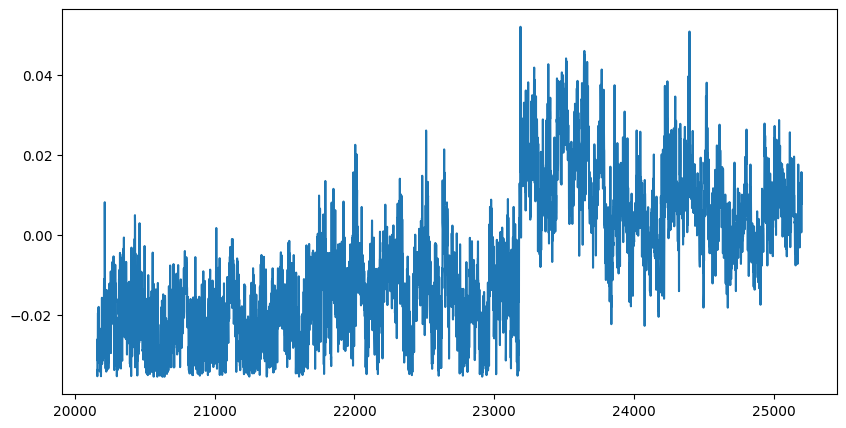

-0.03693471695509244
0.010473789342168494
-0.09703888179696868
4134
         bybit   bitget    spread  enter       pnl
25200  26532.0  26541.5 -0.035799   True  0.007821
25201  26531.9  26540.0 -0.030525   True  0.002547
25202  26525.1  26533.5 -0.031663   True  0.003685
25203  26527.1  26537.0 -0.037313   True  0.009335
25204  26530.0  26537.5 -0.028266   True  0.000288
...        ...      ...       ...    ...       ...
30236  29812.6  29826.0 -0.044937   True  0.016959
30237  29842.4  29855.5 -0.043888   True  0.015910
30238  29869.9  29882.5 -0.042174   True  0.014196
30239  29837.4  29846.5 -0.030494   True  0.002516
30240  29800.0  29823.0 -0.077151   True  0.049173

[5041 rows x 5 columns]


/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['enter'] = abs(observe['spread'] - median_all) >  cost
/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['pnl'] = abs(observe['spread'] - median_all) - cost


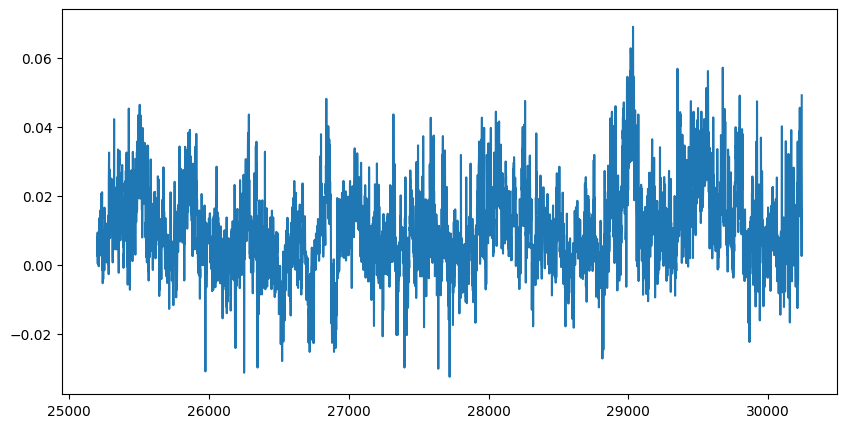

-0.03618351889610455
0.01336678289246927
-0.09586518327909382
4013
         bybit   bitget    spread  enter       pnl
30240  29800.0  29823.0 -0.077151   True  0.049173
30241  29751.0  29772.5 -0.072240   True  0.044262
30242  29821.0  29833.5 -0.041908   True  0.013930
30243  29850.0  29859.0 -0.030146   True  0.002168
30244  29867.0  29877.5 -0.035150   True  0.007172
...        ...      ...       ...    ...       ...
35276  30754.1  30762.0 -0.025684  False -0.002294
35277  30741.7  30751.0 -0.030247   True  0.002269
35278  30740.4  30751.5 -0.036102   True  0.008124
35279  30742.7  30752.0 -0.030247   True  0.002268
35280  30764.1  30772.0 -0.025676  False -0.002302

[5041 rows x 5 columns]


/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['enter'] = abs(observe['spread'] - median_all) >  cost
/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['pnl'] = abs(observe['spread'] - median_all) - cost


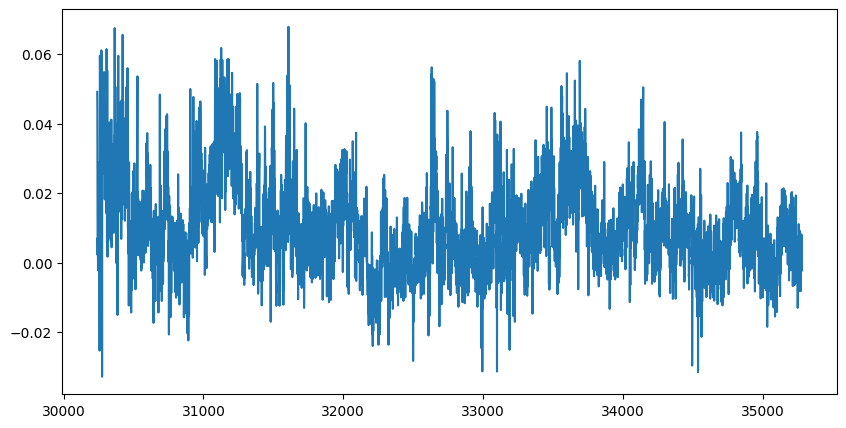

-0.038726489246833036
0.007158405757963653
-0.10232131195003873
4303
         bybit   bitget    spread  enter       pnl
35280  30764.1  30772.0 -0.025676  False -0.002302
35281  30768.1  30777.5 -0.030546   True  0.002568
35282  30842.1  30843.0 -0.002918  False -0.025060
35283  30852.6  30858.0 -0.017501  False -0.010477
35284  30836.9  30849.0 -0.039231   True  0.011253
...        ...      ...       ...    ...       ...
40316  30386.6  30388.5 -0.006253  False -0.021726
40317  30388.6  30398.5 -0.032573   True  0.004595
40318  30398.1  30407.5 -0.030918   True  0.002940
40319  30403.4  30411.5 -0.026638  False -0.001340
40320  30409.6  30417.5 -0.025975  False -0.002003

[5041 rows x 5 columns]


/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['enter'] = abs(observe['spread'] - median_all) >  cost
/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['pnl'] = abs(observe['spread'] - median_all) - cost


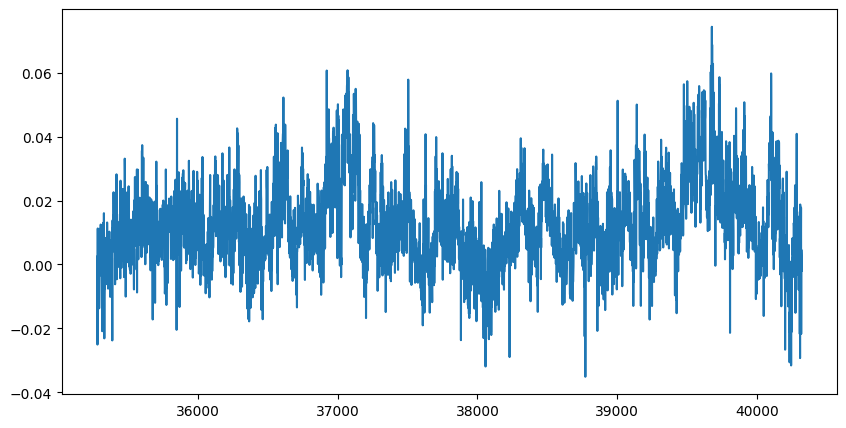

0.0003271924758770633
0.0720728002640473
-0.10460337885517412
1776
         bybit   bitget    spread  enter       pnl
40320  30409.6  30417.5 -0.025975  False -0.002003
40321  30408.9  30416.5 -0.024990  False -0.002989
40322  30411.2  30419.0 -0.025645  False -0.002333
40323  30431.0  30439.0 -0.026286  False -0.001693
40324  30434.9  30440.5 -0.018398  False -0.009580
...        ...      ...       ...    ...       ...
45356  30495.9  30491.5  0.014429  False -0.028593
45357  30496.1  30490.0  0.020005  False -0.023017
45358  30503.2  30499.0  0.013770  False -0.029252
45359  30502.0  30496.0  0.019673  False -0.023349
45360  30499.1  30492.0  0.023282  False -0.019740

[5041 rows x 5 columns]


/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['enter'] = abs(observe['spread'] - median_all) >  cost
/var/folders/tb/f78cb19955g3bp7dl_mj95l40000gn/T/ipykernel_20203/2143040547.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observe['pnl'] = abs(observe['spread'] - median_all) - cost


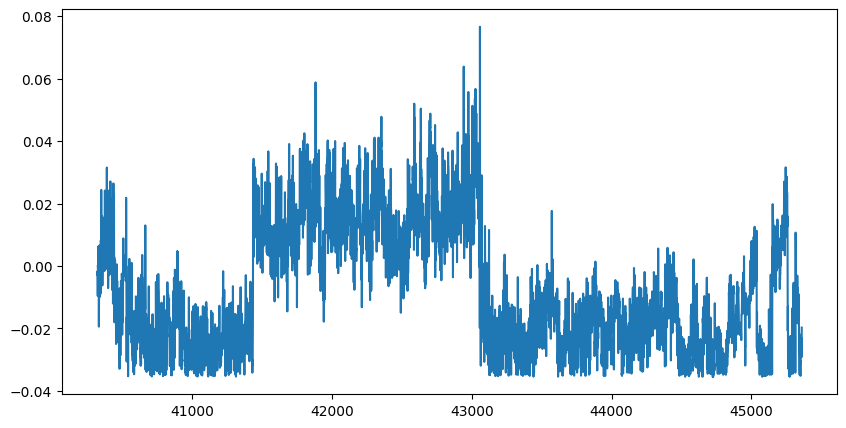

In [225]:
cost = abs(bitget_make + bybit_take + bitget_make + bybit_make) + 0.005
median_all = (data['spread'].median())
for i in range(int(len(data)/5040)):

    observe = data.loc[i*5040:(i+1)*5040]
    median = (observe['spread'].median())
    print(median)
    print(max(observe['spread']))
    print(min(observe['spread']))
#     observe['enter'] = abs(observe['spread'] - median) >  cost
#     observe['pnl'] = abs(observe['spread'] - median) - cost
    observe['enter'] = abs(observe['spread'] - median_all) >  cost
    observe['pnl'] = abs(observe['spread'] - median_all) - cost
    count = observe['enter'].sum()
    print(count)
    print(observe)
    
#     trade = observe[observe['enter'] == True]
#     trade.reset_index(inplace=True)

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(observe.index, observe['pnl'], label='pnl')
#     ax.plot(trade.index, trade['pnl'], label='pnl')
    # ax.axhline(y=sum(spread)/1000, color='red', linestyle='--', label='avg')

    plt.show()

# 以下略過

In [1]:
select_symbol = [  
    "BTC",  
#     "ETH",
#     "BCH",
#     "LTC",
#     "SOL"
]

In [130]:
import requests
import time
import datetime
import pandas as pd

def get_kline(symbol, interval, from_time):
    url = f"https://api.bybit.com/public/linear/kline?symbol={symbol}&interval={interval}&from={from_time}&limit=200"
    response = requests.get(url)
    data = response.json()
    return data['result']

def get_all_kline(symbol, interval, start_date, end_date):
    start_timestamp = int(start_date.timestamp())
    end_date = int(end_date.timestamp())
    all_data = []
    while start_timestamp < end_date:
        data = get_kline(symbol, interval, start_timestamp)
#         print(data)
        all_data.extend(data)
        start_timestamp += 200 * 60 
        time.sleep(0.5)  # avoid rate limit
    return all_data

for symbol in ['BTC']:
    start_date = datetime.datetime(2023, 6, 1)
    end_date = datetime.datetime.now()
    all_data = get_all_kline(f'{symbol}USDT', '1', start_date, end_date)

    df = pd.DataFrame(all_data)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='s')
    df.to_csv(f'/Users/johnsonhsiao/DC_capital/data/bybit/1m_{symbol}.csv')
    print(f'{symbol} is done')

BTC is done


In [14]:
import requests
import time
from datetime import datetime
import pandas as pd

def get_kline(symbol, start_time, end_time):
    url = f"https://api.bitget.com/api/mix/v1/market/history-candles?symbol=BTCUSDT_UMCBL&granularity=1m&startTime={str(start_time)}&endTime={str(end_time)}&limit=200"
    response = requests.get(url)
    data = response.json()
    return data

def get_all_kline(symbol, start_time):
    all_data = []
    start_time_epoch = int(start_time.timestamp()) * 1000
    now_epoch = int(now.timestamp()) * 1000
    while start_time_epoch+60*1000 < now_epoch:
        end_time_epoch = start_time_epoch + 60 * 200 * 1000 
        data = get_kline(symbol, start_time_epoch, end_time_epoch)
#         print(data)
        df = pd.DataFrame(data, columns=['time', 'open', 'high', 'low', 'close', 'volume', 'currency_volume'])
        start_time_epoch = int(df['time'].iloc[-1]) + 60 * 1000 
        df['time'] = pd.to_datetime(df['time'].astype(int) / 1000 , unit='s')
        all_data.append(df)
#         print(all_data)
        time.sleep(0.5)  # avoid rate limit
    return all_data

start_time = datetime(2023, 7, 1)
now = datetime.now()
# now = datetime(2023, 7, 4)
all_data = get_all_kline('BTCUSDT_UMCBL', start_time)
bitget = pd.concat(all_data)

bitget.reset_index(drop=True, inplace=True)
bitget

,time,open,high,low,close,volume,currency_volume
0,2023-06-30 16:00:00,30042.5,30045,30008.5,30015,88.122,2646240.4035
1,2023-06-30 16:01:00,30015,30018,30007.5,30011.5,59.658,1790415.466
2,2023-06-30 16:02:00,30011.5,30023,30011.5,30020,61.236,1838365.3065
3,2023-06-30 16:03:00,30020,30027,30002.5,30003.5,140.795,4226295.6795
4,2023-06-30 16:04:00,30003.5,30020,29997,30018.5,71.715,2152164.997
...,...,...,...,...,...,...,...
24195,2023-07-17 09:00:00,30241,30241,30233.5,30236.5,71.863,2172873.8645
24196,2023-07-17 09:01:00,30236.5,30250,30236.5,30250,67.859,2052391.144
24197,2023-07-17 09:02:00,30250,30254.5,30250,30254.5,91.944,2781613.915
24198,2023-07-17 09:03:00,30254.5,30254.5,30250,30250,31.392,949643.5725


In [15]:
bitget_df = bitget.drop_duplicates(subset='time')
# bitget_df = bitget_df.drop(df.index[-1])
bitget_df.reset_index(inplace=True)
bitget_df = bitget_df[:-8]
bitget_df.to_csv('/Users/johnsonhsiao/DC_capital_intern/bitget/July_1m.csv')


In [4]:
bybit = pd.read_csv('./bybit/July_1m_BTC.csv')
bitget = pd.read_csv('./bitget/July_1m.csv')

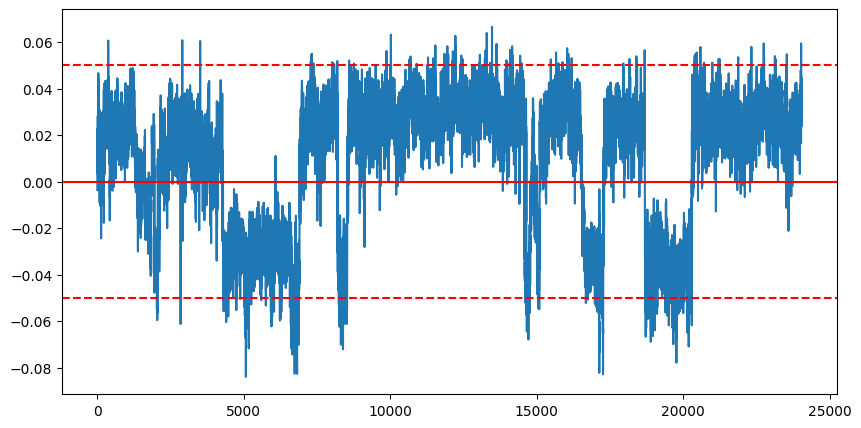

In [6]:
import matplotlib.pyplot as plt
import numpy as np

spread = ((bybit['close'] - bitget['close'].astype(float)) / ((bybit['close'] + bitget['close'].astype(float)) / 2)) * 100
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(bybit.index, spread, label='spread')
ax.axhline(y=0, color='red', linestyle='-', label='0')
ax.axhline(y=0.05, color='red', linestyle='--', label='0')
ax.axhline(y=-0.05, color='red', linestyle='--', label='0')
plt.show()

In [2]:
import pandas as pd